<a href="https://colab.research.google.com/github/mainaak03/Diabetes_prediction/blob/main/diabetes_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA

In [3]:
data = pd.read_csv('/content/gdrive/My Drive/datasets/diabetes.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

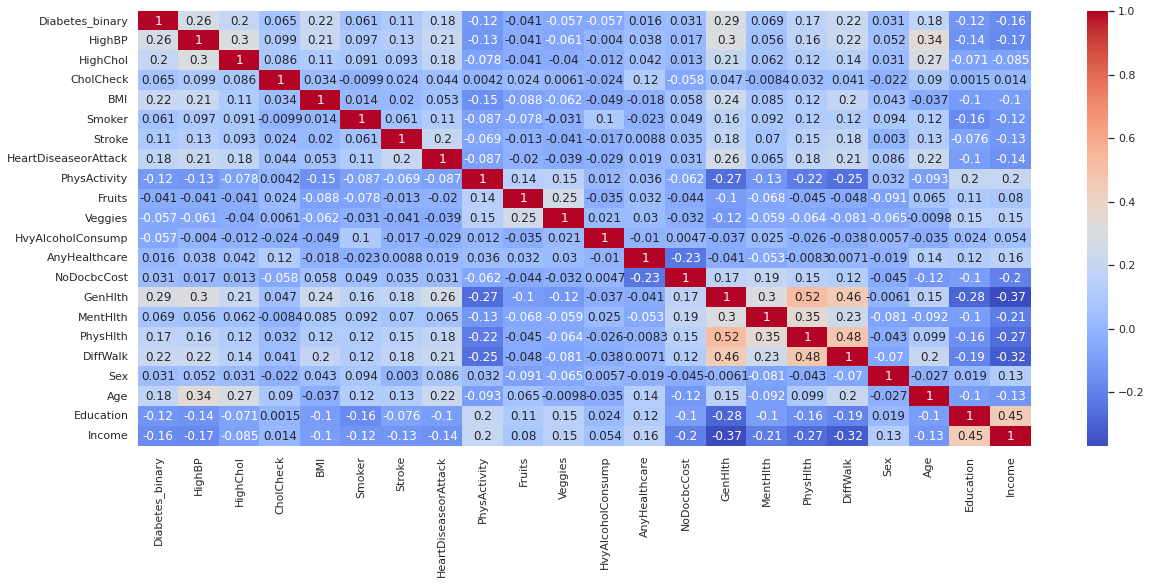

In [5]:
sns.set(rc = {'figure.figsize':(20,8)})
sns.heatmap(data.corr(), annot = True, fmt='.2g',cmap= 'coolwarm')

**We can see from the heatmap that feature "AnyHealthcare" has very low corr with our target and features Education and Income have negative correlation. Also it is unlikely that Education affects occurence of diabetes in a person. We will also drop MentHlth and PhysHlth because they represent only data of last 30 days which is unlikely to help our model.So we will drop these columns and create our final dataset. Then we split this dataset into our train and test sets with 0.8 train_size.**

**Columns Fruits and Veggies can b converted to one row with value 1 if any of the former columns is 1. Also both of those columns have low negative correlation,  so they can be merged together without drastically affecting model accuracy.**

In [6]:
final_data = data.drop(columns=["AnyHealthcare", "Education", "Income", "MentHlth", "PhysHlth", "CholCheck"])
y = final_data["Diabetes_binary"]
x = final_data.drop(columns=["Diabetes_binary"])

FruitVeg = [(int(x["Fruits"][i]) | int(x["Veggies"][i])) for i in x.index]
x.insert(9, "FruitVeg", FruitVeg, True)
x = x.drop(columns=["Fruits", "Veggies"])

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=0)

In [7]:
x.head()

,HighBP,HighChol,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,FruitVeg,HvyAlcoholConsump,NoDocbcCost,GenHlth,DiffWalk,Sex,Age
0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,1,0.0,0.0,5.0,1.0,0.0,9.0
1,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0,0.0,1.0,3.0,0.0,0.0,7.0
2,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1,0.0,1.0,5.0,1.0,0.0,9.0
3,1.0,0.0,27.0,0.0,0.0,0.0,1.0,1,0.0,0.0,2.0,0.0,0.0,11.0
4,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1,0.0,0.0,2.0,0.0,0.0,11.0


**Now we create a Random Forest model to figure out which features affect our output the most.**

In [10]:
f_model = RandomForestClassifier(random_state=0)
f_model.fit(x_train, y_train)

RandomForestClassifier(random_state=0)

In [35]:
importances = pd.DataFrame(f_model.feature_importances_)
importances.insert(0, "Feature", x_train.columns, True)
importances.columns = ["Feature", "Importance"]
importances = importances.sort_values(by="Importance", ascending=False)
importances

,Feature,Importance
2,BMI,0.354733
13,Age,0.209805
10,GenHlth,0.113604
0,HighBP,0.054945
11,DiffWalk,0.036444
1,HighChol,0.034931
3,Smoker,0.034625
12,Sex,0.030746
6,PhysActivity,0.029705
7,FruitVeg,0.027232


**From the Random Forest model,  we can see that BMI, Age, General Health are the most important features. HighBP also plays a major role in determining the chance of diabetes but has comparitively lower score than the former features.**

In [53]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import accuracy_score

In [62]:
space = {'max_depth': hp.quniform("max_depth", 3, 10, 1),
        'gamma': hp.uniform ('gamma', 1, 9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'learning_rate': hp.choice('learning_rate', [0.5, 0.1, 0.05, 0.01]),
        'n_estimators': hp.choice('n_estimators', [100, 200, 300, 400, 500, 750, 1000])
      }

In [63]:
x_train_f, x_valid, y_train_f, y_valid = train_test_split(x_train, y_train, train_size=0.8)

In [64]:
x_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40589 entries, 188312 to 175634
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   HighBP                40589 non-null  float64
 1   HighChol              40589 non-null  float64
 2   BMI                   40589 non-null  float64
 3   Smoker                40589 non-null  float64
 4   Stroke                40589 non-null  float64
 5   HeartDiseaseorAttack  40589 non-null  float64
 6   PhysActivity          40589 non-null  float64
 7   FruitVeg              40589 non-null  int64  
 8   HvyAlcoholConsump     40589 non-null  float64
 9   NoDocbcCost           40589 non-null  float64
 10  GenHlth               40589 non-null  float64
 11  DiffWalk              40589 non-null  float64
 12  Sex                   40589 non-null  float64
 13  Age                   40589 non-null  float64
dtypes: float64(13), int64(1)
memory usage: 4.6 MB


In [65]:
def objective_fn(space):
  model = XGBClassifier(n_estimators=int(space["n_estimators"]), max_depth=int(space["max_depth"]), gamma=space["gamma"], reg_alpha=space["reg_alpha"], reg_lambda=space["reg_lambda"], colsample_bytree=space["colsample_bytree"], learning_rate=space["learning_rate"], random_state=0)
  eval = [(x_valid, y_valid)]

  model.fit(x_train, y_train, early_stopping_rounds=5, eval_set=eval, eval_metric="auc")

  pred = model.predict(x_valid)
  accuracy = accuracy_score(y_valid, pred)
  print("SCORE:", accuracy)
  return {'loss': -accuracy, 'status': STATUS_OK }

In [66]:
trials = Trials()

best_params = fmin(fn=objective_fn, space=space,  algo=tpe.suggest,  max_evals=100,  trials=trials)

Streaming output truncated to the last 5000 lines.
[66]	validation_0-auc:0.828205

[67]	validation_0-auc:0.828217

[68]	validation_0-auc:0.828228

[69]	validation_0-auc:0.828228

[70]	validation_0-auc:0.828236

[71]	validation_0-auc:0.828246

[72]	validation_0-auc:0.828263

[73]	validation_0-auc:0.828303

[74]	validation_0-auc:0.828303

[75]	validation_0-auc:0.828297

[76]	validation_0-auc:0.828299

[77]	validation_0-auc:0.82833

[78]	validation_0-auc:0.82835

[79]	validation_0-auc:0.828338

[80]	validation_0-auc:0.828338

[81]	validation_0-auc:0.828359

[82]	validation_0-auc:0.828359

[83]	validation_0-auc:0.828359

[84]	validation_0-auc:0.828374

[85]	validation_0-auc:0.828393

[86]	validation_0-auc:0.828393

[87]	validation_0-auc:0.828424

[88]	validation_0-auc:0.828417

[89]	validation_0-auc:0.828417

[90]	validation_0-auc:0.828424

[91]	validation_0-auc:0.828429

[92]	validation_0-auc:0.828429

[93]	validation_0-auc:0.828453

[94]	validation_0-auc:0.828453

[95]	validation_0-auc:0

In [67]:
print(best_params)

{'colsample_bytree': 0.8175358939041211, 'gamma': 1.59979325299709, 'learning_rate': 1, 'max_depth': 10.0, 'n_estimators': 3, 'reg_alpha': 69.0, 'reg_lambda': 0.570054717357137}


In [70]:
final_model = XGBClassifier(n_estimators=400, max_depth=10, gamma=1.59979325299709, reg_alpha=69.0, reg_lambda=0.570054717357137, colsample_bytree=0.8175358939041211, learning_rate=0.1, early_stopping_rounds=5, random_state=0)

final_model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], verbose=1)


[0]	validation_0-error:0.138461
[1]	validation_0-error:0.13819
[2]	validation_0-error:0.134667
[3]	validation_0-error:0.133731
[4]	validation_0-error:0.134051
[5]	validation_0-error:0.134667
[6]	validation_0-error:0.134495
[7]	validation_0-error:0.134273
[8]	validation_0-error:0.133903
[9]	validation_0-error:0.134125
[10]	validation_0-error:0.133977
[11]	validation_0-error:0.133706
[12]	validation_0-error:0.133657
[13]	validation_0-error:0.133558
[14]	validation_0-error:0.133608
[15]	validation_0-error:0.133706
[16]	validation_0-error:0.133657
[17]	validation_0-error:0.133657
[18]	validation_0-error:0.133632
[19]	validation_0-error:0.133583
[20]	validation_0-error:0.133558
[21]	validation_0-error:0.13346
[22]	validation_0-error:0.133509
[23]	validation_0-error:0.133411
[24]	validation_0-error:0.133583
[25]	validation_0-error:0.133484
[26]	validation_0-error:0.133361
[27]	validation_0-error:0.133312
[28]	validation_0-error:0.133238
[29]	validation_0-error:0.133189
[30]	validation_0-erro

XGBClassifier(colsample_bytree=0.8175358939041211, early_stopping_rounds=5,
              gamma=1.59979325299709, max_depth=10, n_estimators=400,
              reg_alpha=69.0, reg_lambda=0.570054717357137)

In [80]:
pred = final_model.predict(x_test)

print("Model accuracy: ", accuracy_score(y_test, pred), "\n")
print(sklearn.metrics.classification_report(y_test, pred))

Model accuracy:  0.8655983916745507 

              precision    recall  f1-score   support

         0.0       0.88      0.98      0.93     43525
         1.0       0.61      0.15      0.25      7211

    accuracy                           0.87     50736
   macro avg       0.74      0.57      0.59     50736
weighted avg       0.84      0.87      0.83     50736



[[42800   725]
 [ 6094  1117]]


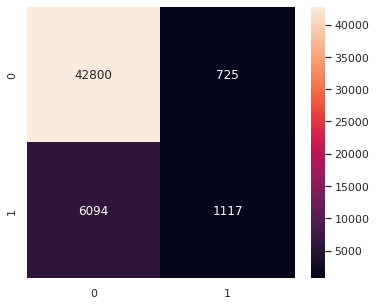

In [90]:
print(sklearn.metrics.confusion_matrix(y_test, pred))
sns.set(rc = {'figure.figsize':(6,5)})
sns.heatmap(sklearn.metrics.confusion_matrix(y_test, pred), annot=True, fmt='d')

In [94]:
final_importances = pd.DataFrame({'Feature': x_train.columns, 'Relative Importance': final_model.feature_importances_})
final_importances

,Feature,Relative Importance
0,HighBP,0.654295
1,HighChol,0.050252
2,BMI,0.048405
3,Smoker,0.002397
4,Stroke,0.003105
5,HeartDiseaseorAttack,0.013495
6,PhysActivity,0.003789
7,FruitVeg,0.002596
8,HvyAlcoholConsump,0.018529
9,NoDocbcCost,0.001860
